In [1]:
%matplotlib inline
from numpy import *
from pylab import *
from numpy.polynomial.polynomial import *
from numpy.polynomial.chebyshev import chebgauss


In [2]:


#INTRODUCIAMO chebishev per produrre lo spazio duale

def chebyshev_nodes(num_nodes):
    #cheb = [0.5*cos((2*(i+1)-1)*pi/(2*x)) + 0.5 for i in range(num_nodes)]
    #cheb = array(cheb)
    cheb = 0.5 * chebgauss(num_nodes)[0] + 0.5
    return sort(cheb)

def lagrange_basis(nodes, i):
    num = arange(len(nodes))
    d = product([ (nodes[i]-nodes[j]) for j in num if j != i], axis=0)
    def func(x):
        L = product([ (x - nodes[j]) for j in num if j != i], axis=0) / d
        return L
    return func

def lagrange_basis_derivatives(nodes, i):
    num = arange(len(nodes))
    d = product([ (nodes[i]-nodes[j]) for j in num if j != i], axis=0)
    def func(x):
        L_deriv = sum( [ product( [ (x - nodes[j]) for j in num if (j != i and j != k) ], axis=0) for k in num if k != i ], axis=0 ) / d
        return L_deriv
    return func



In [3]:
from numpy.polynomial.legendre import leggauss

dim = 3
degree = 5 #grado dei polinomi delle basi 

num_q = 2 * degree + 1
q,w = leggauss(num_q) # Gauss between -1 and 1
q = (q+1)/2 # to go back to 0,1
w = w/2

In [4]:
cheb = chebyshev_nodes(degree+1) #Lista nodi chebichev

n = degree + 1 # Dim poly space


lag_bas=[]
lag_bas_deriv=[]
V = []
V_prime=[]

#lagrangian base per i punti chebichev
for i in range(len(cheb)):
    lag_bas.append(lagrange_basis(cheb,i))
    lag_bas_deriv.append(lagrange_basis_derivatives(cheb,i))


Vq = zeros((n, len(q)))
Vpq = zeros((n, len(q)))

    #Le righe di Vq sono le funzioni di base calcolate sui punti di quadratura
for i in range(n):
    Vq[i] = lag_bas[i](q)
    Vpq[i] = lag_bas_deriv[i](q)

VVV    = einsum('ij,kl,nm -> inkljm', Vq, Vq, Vq, optimize=True)
VVVp   = einsum('ij,kl,nm -> inkljm', Vq, Vq, Vpq, optimize=True)
VVpV   = einsum('ij,kl,nm -> inkljm', Vq, Vpq, Vq, optimize=True)
VpVV   = einsum('ij,kl,nm -> inkljm', Vpq, Vq, Vq, optimize=True)
    #VpVpVp = einsum('ij,kl,nm -> inkljm', Vpq, Vpq, Vpq, optimize=True)

VVV  = reshape(VVV,  (prod(VVV.shape[:dim]),  prod(VVV.shape[dim:])))
VVVp = reshape(VVVp, (prod(VVVp.shape[:dim]), prod(VVVp.shape[dim:])))
VVpV = reshape(VVpV, (prod(VVpV.shape[:dim]), prod(VVpV.shape[dim:])))
VpVV = reshape(VpVV, (prod(VpVV.shape[:dim]), prod(VpVV.shape[dim:])))

W = einsum('i,j,k -> ijk', w, w, w, optimize=True)
W = reshape(W, (prod(W.shape[:dim])))


latticeq_points = array([[[[qx,qy,qz] for qz in q] for qy in q ] for qx in q])
latticeq_points = latticeq_points.reshape(len(q)*len(q)*len(q),dim)

lpoint_x = array([latticeq_points[i,0] for i in range(len(latticeq_points))])
lpoint_y = array([latticeq_points[i,1] for i in range(len(latticeq_points))])
lpoint_z = array([latticeq_points[i,2] for i in range(len(latticeq_points))])


In [5]:
import scipy.sparse.linalg

# -------------------------------------------------

A = einsum('jq, iq, q -> ij', VVVp, VVVp, W, optimize=True)
A += einsum('jq, iq, q -> ij', VVpV, VVpV, W, optimize=True)
A += einsum('jq, iq, q -> ij', VpVV, VpVV, W, optimize=True)

M = einsum('jq, iq, q -> ij', VVV, VVV, W, optimize=True)


    # -------------------------------------------------
    
my_f = lambda x,y,z: (3*(pi**2) + 1)*cos(pi*y)*cos(pi*x)*cos(pi*z)

RHS = einsum('iq, q, q -> i', VVV, W, my_f(lpoint_x,lpoint_y,lpoint_z), optimize=True)

    # -------------------------------------------------


P = diag( diag(A + M) ) # Preconditioner

invP = linalg.inv(P)

u_fe = scipy.sparse.linalg.cg( A + M, RHS, M = invP)

u_fe = array(u_fe[0])

Vcheb = zeros((n, len(cheb)))

for j in range(degree + 1):
    Vcheb[j] = lag_bas[j](cheb)

C = einsum('is, jk, nm -> skmijn', Vcheb, Vcheb, Vcheb, optimize=True)

#print C.shape
#print u_fe.reshape((n, n, n)).shape

sol = einsum('skmijn, ijn', C, u_fe.reshape((n, n, n)), optimize=True)



[[[ 0.99556177  0.89344427  0.39417918 -0.39417918 -0.89344427 -0.99556177]
  [ 0.89344427  0.80180124  0.35374715 -0.35374715 -0.80180124 -0.89344427]
  [ 0.39417918  0.35374715  0.1560699  -0.1560699  -0.35374715 -0.39417918]
  [-0.39417918 -0.35374715 -0.1560699   0.1560699   0.35374715  0.39417918]
  [-0.89344427 -0.80180124 -0.35374715  0.35374715  0.80180124  0.89344427]
  [-0.99556177 -0.89344427 -0.39417918  0.39417918  0.89344427  0.99556177]]

 [[ 0.89344427  0.80180124  0.35374715 -0.35374715 -0.80180124 -0.89344427]
  [ 0.80180124  0.7195583   0.31746233 -0.31746233 -0.7195583  -0.80180124]
  [ 0.35374715  0.31746233  0.14006139 -0.14006139 -0.31746233 -0.35374715]
  [-0.35374715 -0.31746233 -0.14006139  0.14006139  0.31746233  0.35374715]
  [-0.80180124 -0.7195583  -0.31746233  0.31746233  0.7195583   0.80180124]
  [-0.89344427 -0.80180124 -0.35374715  0.35374715  0.80180124  0.89344427]]

 [[ 0.39417918  0.35374715  0.1560699  -0.1560699  -0.35374715 -0.39417918]
  [ 0.35

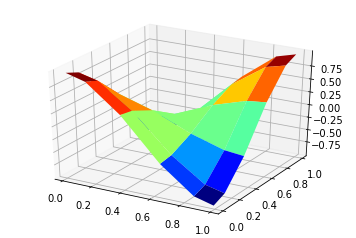

In [6]:
u_exact = lambda x,y,z: cos(pi*x)*cos(pi*y)*cos(pi*z)

X, Y = meshgrid(cheb,cheb)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, sol[:,:,0], cmap = cm.jet)
plt.show()

In [135]:
# mod